In [114]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


In [115]:
path='training_data/target{}.csv'.format(0)
train_data=pd.read_csv(path)

# open_mean=train_data.mean()[0]
# open_std=train_data.std()[0]
# print(train_data['time'][0])
# train_data.head()


In [116]:
def get_data(df, days_to_train=7, days_to_pred=1):
    # 用前7天預測當天
    generation=[]
    consumption=[]

    g_x, g_y = [], []
    c_x, c_y = [], []

    # df=df.apply(lambda x:(x-x.mean())/ x.std())
    
    for i in range(int(df.shape[0]/24)):
        # 243 days
        generation.append(np.array(df['generation'][24*i:24*(i+1)],dtype=np.float32))
        consumption.append(np.array(df['consumption'][24*i:24*(i+1)],dtype=np.float32))

    for i in range(len(generation)-days_to_train):
        g_x.append(generation[i:(i+days_to_train)])
        g_y.append(generation[i+days_to_train])
        c_x.append(consumption[i:(i+days_to_train)])
        c_y.append(consumption[i+days_to_train])

    return np.array(g_x), np.array(g_y), np.array(c_x), np.array(c_y)

class DataSet(Dataset):

    def __init__(self, a, b, trans):
        self.train=a
        self.valid=b
        self.transform=trans

    def __getitem__(self, index) :
        x=self.train[index]
        y=self.valid[index]

        x=self.transform(x)
        # y=self.transform(y)

        return x, y

    def __len__(self):

        return len(self.train)

In [117]:
G_X, G_Y, C_X, C_Y=get_data(train_data)
# print(G_X.shape)
print(len(G_X))


generation_x, generation_y=G_X[:int(len(G_X)*0.8)], G_Y[:int(len(G_Y)*0.8)]
generation_valid_x, generation_valid_y=G_X[int(len(G_X)*0.8):], G_Y[int(len(G_Y)*0.8):]

transform=transforms.Compose([
    transforms.ToTensor(),
])
train_loader=DataLoader(dataset=DataSet(generation_x, generation_y, transform),batch_size=24,shuffle=True)
valid_loader=DataLoader(dataset=DataSet(generation_valid_x, generation_valid_y, transform),batch_size=24,shuffle=True)


236


In [118]:
class LSTM(torch.nn.Module):
    def __init__(self, input=24, hidden_size=128, output=24):
        # Input of LSTM : batch, sequence_len, input_size
        super(LSTM, self).__init__()

        self.rnn=torch.nn.LSTM(input, hidden_size, batch_first=True)
        self.linear=torch.nn.Linear(hidden_size, output)

    def forward(self,x):
        out, (hidden, cell) = self.rnn(x)
        a, b, c = hidden.shape
        # print(hidden.reshape(a*b,c).shape)
        out = self.linear(hidden.reshape(a*b,c))
        
        return out

# LSTM=torch.nn.LSTM(24,32,batch_first=True)

In [119]:
EPOCH = 50
LR = 0.001

device = 'cpu'
if torch.cuda.is_available(): # 若想使用 cuda 且可以使用 cuda
    device = 'cuda'

print('Using %s'%device)

Using cuda


In [120]:
model = LSTM()
model=model.to(device)
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr = LR)

print(model)

LSTM(
  (rnn): LSTM(24, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=24, bias=True)
)


In [121]:
# Train model

preds=[]
targets=[]

for i in range(EPOCH):
    print('============EPOCH {}============'.format(i+1))
    
    model.train()
    train_loss=0
    for _, (data, label) in enumerate(tqdm(train_loader)):
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        # print(data.shape)
        pred=model(data.squeeze())
        # print(pred.shape)
        label=label.unsqueeze(1)

        loss=criterion(pred, label)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        # print(label.unsqueeze(1).shape)
        # print(pred.shape)
        # break
        
    

    # Validate model
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for _, (data, label) in enumerate(tqdm(valid_loader)):
            data, label = data.to(device), label.to(device)

            pred=model(data.squeeze())
            # print(data.shape)
            label=label.unsqueeze(1)

            loss = criterion(pred, label)

            valid_loss+=loss.item()

            preds.extend(pred.squeeze().tolist())
            targets.extend(label.squeeze().tolist())
            # break
        
        print("Train loss:%s" % train_loss)
        print("Valid loss:%s" % valid_loss)

torch.save(model,'LSTM.pt')

# print(len(preds))
# print(len(targets))

============EPOCH 1============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])


C:\Python\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([24, 1, 24])) that is different to the input size (torch.Size([24, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Python\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([20, 1, 24])) that is different to the input size (torch.Size([20, 24])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 8/8 [00:00<00:00, 229.18it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 401.06it/s]


Train loss:19.902999758720398
Valid loss:3.8599743843078613
============EPOCH 2============


100%|██████████| 8/8 [00:00<00:00, 248.22it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 334.13it/s]


Train loss:11.420194327831268
Valid loss:1.0756807923316956
============EPOCH 3============


100%|██████████| 8/8 [00:00<00:00, 222.82it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 501.20it/s]


Train loss:5.662347614765167
Valid loss:0.2525772973895073
============EPOCH 4============


100%|██████████| 8/8 [00:00<00:00, 211.09it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 501.29it/s]


Train loss:4.892710715532303
Valid loss:0.24975620210170746
============EPOCH 5============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 250.47it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.36it/s]


Train loss:4.857008546590805
Valid loss:0.32204295694828033
============EPOCH 6============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 250.68it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 401.10it/s]


Train loss:4.721246063709259
Valid loss:0.3198172301054001
============EPOCH 7============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 267.76it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 498.70it/s]


Train loss:4.663295358419418
Valid loss:0.3187045753002167
============EPOCH 8============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.31it/s]


Train loss:4.683131009340286
Valid loss:0.32418689131736755
============EPOCH 9============


100%|██████████| 8/8 [00:00<00:00, 258.75it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 501.47it/s]


Train loss:4.656115502119064
Valid loss:0.31215251982212067
============EPOCH 10============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 501.32it/s]


Train loss:4.659944951534271
Valid loss:0.32021355628967285
============EPOCH 11============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.57it/s]


Train loss:4.741813957691193
Valid loss:0.2611912488937378
============EPOCH 12============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 258.76it/s]


torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.47it/s]


Train loss:4.700798511505127
Valid loss:0.34939686954021454
============EPOCH 13============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 267.38it/s]


torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 500.96it/s]


Train loss:4.702700823545456
Valid loss:0.3214983493089676
============EPOCH 14============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.36it/s]


Train loss:4.658585488796234
Valid loss:0.29624906182289124
============EPOCH 15============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 242.89it/s]


torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 662.76it/s]


Train loss:4.6917644739151
Valid loss:0.2897377461194992
============EPOCH 16============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 662.92it/s]


Train loss:4.674499034881592
Valid loss:0.337886780500412
============EPOCH 17============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 243.08it/s]


torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.31it/s]


Train loss:4.681517511606216
Valid loss:0.3382761478424072
============EPOCH 18============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.41it/s]


Train loss:4.719551384449005
Valid loss:0.27267634123563766
============EPOCH 19============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 250.42it/s]


torch.Size([24, 24])
torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 989.69it/s]


Train loss:4.6776977479457855
Valid loss:0.29645927250385284
============EPOCH 20============


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


100%|██████████| 8/8 [00:00<00:00, 216.79it/s]


torch.Size([20, 24])


100%|██████████| 2/2 [00:00<00:00, 668.52it/s]


Train loss:4.659411519765854
Valid loss:0.34550705552101135
============EPOCH 21============


 50%|█████     | 4/8 [00:00<00:00, 211.09it/s]

torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])
torch.Size([24, 24])


KeyboardInterrupt: 

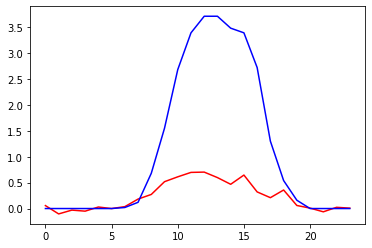

In [ ]:
# Test
plt.plot(preds[:10][0],'r',label='Prediction')
plt.plot(targets[:10][0],'b',label='Real data')
plt.show()
# print(len(preds))
# print(targets[0][0])

In [ ]:
# Test data
test_data=pd.read_csv('testing.csv',header=None)
test_mean, test_std = test_data.mean()[0], test_data.std()[0]
open_price=test_data[0]
test_data=test_data.apply(lambda x:(x-x.mean())/ x.std())

X=[]
days_to_used=2
for i in range(test_data.shape[0]-days_to_used):
    X.append(np.array(test_data.iloc[i:(i+days_to_used)],dtype=np.float32))
test_set=np.array(X)
# print(test_set.shape)
test_set=transform(test_set)
test_set=test_set.permute(1, 2, 0)
# print(test_set.shape)
test_set=test_set.to(device)

# for _, (data, label) in enumerate((valid_loader)):
#     print(data.shape)
#     break
model.eval()
with torch.no_grad():
    test_pred=model(test_set)
test_pred=test_pred.squeeze().tolist()
test_pred.insert(0,0)
test_pred.insert(0,0)
# print(test_pred)

# plt.plot([(i*test_std)+test_mean for i in test_pred],'r',label='Prediction')
# plt.plot(open_price,'b',label='Real data')
# plt.show()

actions=[]
unit=0
my_price=0
for i in range(len(open_price)-1):
    
    if i < 1:
        actions.append(0)
        continue

    today_price=open_price[i]
    pred_price=test_pred[i+1]*test_std+test_mean
    if my_price < pred_price and unit == 1:
        # Sell
        actions.append(-1)
        unit-=1
    elif today_price > pred_price and unit == 0:
        # Buy
        actions.append(1)
        my_price=open_price[i+1]
        unit+=1
    else:
        actions.append(0)
    # print(i)

submission=pd.DataFrame({
    'Action':actions
})
submission.to_csv('output.csv',header=None, index=False)

# print(submission)



FileNotFoundError: [Errno 2] No such file or directory: 'testing.csv'